Train simple forests and try to interpret

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
predictors = pd.read_csv("out_data/forest_data_poland_lucas.csv", sep=" ",  index_col=False, na_values = 48,
                         header = None)
pd.set_option('display.max_columns',None)


Better variable names

In [3]:
predictors_names = pd.read_csv("out_data/available_features_names.csv", sep=",",  index_col=False)
predictors.columns = predictors_names.name.tolist()
predictors.tail(5)

,GLAD_mean100m,GLAD_median100m,GLAD_mode100m,GLAD_q1,GLAD_q3,CLC10m_mean,CLC10m_median,CLC10m_mode.,CLC10m_q1,CLC10m_q3,CLC_01.vrt,C-GLOPS_mean,C-GLOPS_median,C-GLOPS_mode,C-GLOPS_q1,C-GLOPS_q3,JAXA_q3,JAXA_q1,JAXA_mode,JAXA_median,JAXA_mean
23079,0.246136,0,0,0,1,0.60,1,1,0,1,0,0.191063,0.07,0.07,0.04,0.08,0.5,0.0,0.0,0.0,0.277736
23080,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.016844,0.01,0.01,0.01,0.03,0.0,0.0,0.0,0.0,0.000000
23081,0.932173,1,1,1,1,0.95,1,1,1,1,1,0.402705,0.44,0.39,0.39,0.62,1.0,1.0,1.0,1.0,0.961699
23082,0.000000,0,0,0,0,0.00,0,0,0,0,0,0.043004,0.03,0.03,0.02,0.03,0.0,0.0,0.0,0.0,0.023998
23083,0.000000,0,0,0,0,0.09,0,0,0,0,0,0.098559,0.09,0.06,0.06,0.11,0.0,0.0,0.0,0.0,0.000000


Now the left hand side

In [4]:
outcome = pd.read_csv("out_data/LUCAS/LUCAS_locations.csv", sep=",",  index_col=False)
outcome.tail(5)

,X,Y,LC1,LC1_PERC,forest
23079,5.278000e+06,3.114000e+06,C22,100,1
23080,5.278000e+06,3.136000e+06,B11,100,0
23081,5.294000e+06,3.150000e+06,C10,100,1
23082,5.294000e+06,3.172000e+06,B11,92,0
23083,5.286000e+06,3.116000e+06,Bx1,98,0


In [5]:
print (len(outcome))
print (len(predictors))

23084
23084


In [6]:
outcome.head()

,X,Y,LC1,LC1_PERC,forest
0,5.214000e+06,3.064000e+06,B16,95,0
1,5.214000e+06,3.116000e+06,E20,100,0
2,5.214000e+06,3.388000e+06,C10,100,1
3,5.214000e+06,3.474000e+06,B16,1,0
4,4.792000e+06,3.082000e+06,B14,50,0


Split the Dataset

In [7]:
X    = predictors
Y    = outcome.iloc[:,4].to_frame()
feat = predictors.columns.values
print(X.shape)
print(Y.shape)
print(type(X))
print(type(Y))

(23084, 21)
(23084, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


There are a handful of NAs

In [8]:
na_rows = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
result = np.where(na_rows)[0]
print('NA rows: ' + str(result))

NA rows: [   33    54    58 ... 23032 23046 23077]


In [9]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])


In [10]:
print(X.shape)
print(Y.shape)

(21819, 21)
(21819, 1)


Create 4 dataset for training and testing the algorithm 

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2023)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

In [12]:
print(np.mean(y_train==1))
print(np.mean(y_test==1))

0.3208360069667247
0.3242896425297892


Use wandb to seach the model space 

In [13]:
import wandb

In [14]:
wandb.init(project="RF_Foresthybrid_sweep")

wandb: Currently logged in as: hofer1991 (nodes). Use `wandb login --relogin` to force relogin
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [ ]:
#wandb.sklearn.plot_confusion_matrix(y_train, dic_pred['train'])



In [15]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'Accuracy/val',
      'goal': 'maximize'   
    },
    'parameters': {
        'tree__min_samples':{
            'distribution': 'uniform',
            'min' : 0.2 ,
            'max' : 0.9
        },
        'tree__max_depth':{
            'distribution': 'int_uniform',
            'min' : 1 ,
            'max' : 10
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="hofer1991", project="SingleSimpleTree_Foresthybrid_sweep")

In [14]:
# Training and Evaluation routines for Sweeping
def performance_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tn + tp + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fn)
    bacc= (tpr + tnr) * 0.5
#    f1 = (tpr * tnr) / (tpr + tnr)
    return(acc)

def evaluate(model, X, y):
    y_pred = model.predict(X) 
    metric  = performance_metrics(y, y_pred)
    return(metric)
    
def train(config=None):
    with wandb.init(config=config):
        
        # Config is a variable that holds and saves hyperparameters and inputs
        config = wandb.config
        
        TreeClassifier = tree.DecisionTreeClassifier(
                    # max_features=config.tree__max_features,
                    max_depth   =config.tree__max_depth,
                    min_samples_split=config.tree__min_samples) 
        
        TreeClassifier.fit(X_train, y_train)
        
        
        acc_train = evaluate(TreeClassifier,X_train, y_train)
        acc_test = evaluate(TreeClassifier, X_test, y_test)
        
        wandb.log({
                "Accuracy/train": acc_train,
                "Accuracy/val": acc_test
        })
        

In [ ]:
wandb.agent(sweep_id, train)

In [15]:
TreeClassifier = tree.DecisionTreeClassifier(
                    max_depth=10,
                    min_samples_split=0.3) 

TreeClassifier.fit(X_train, y_train)
        
        
evaluate(TreeClassifier, X_test, y_test)

0.8944087992667278

In [16]:
from sklearn import tree
import matplotlib.pyplot as plt
from datetime import datetime

# get current date and time
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H-%M-%S")

# create a unique filename based on the current date and time
filename = f'fgood_model_{dt_string}.sav'

# save the model to disk
joblib.dump(rfc, filename)

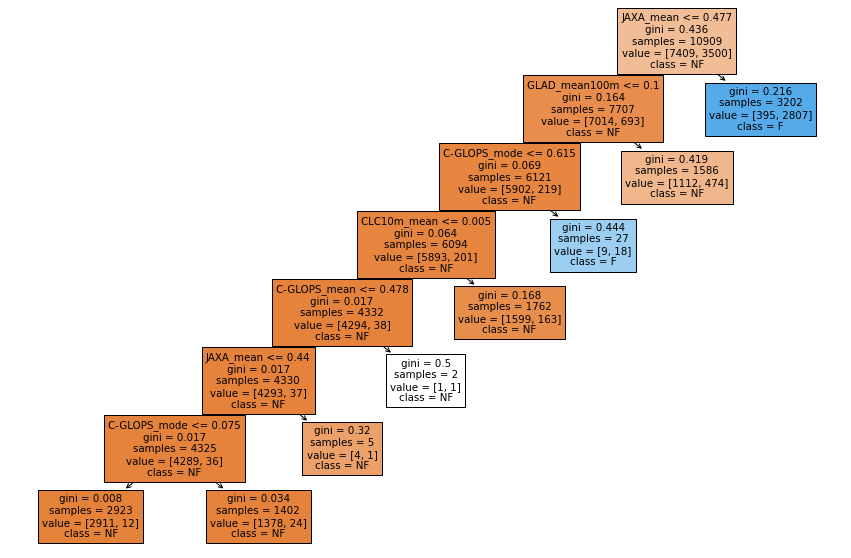

In [17]:
plt.figure(figsize=(15,10))
tree.plot_tree(TreeClassifier, 
               feature_names = X.columns, 
               class_names= ["NF","F"], 
               filled = True)

plt.show()

[[6967  405]
 [ 747 2791]]


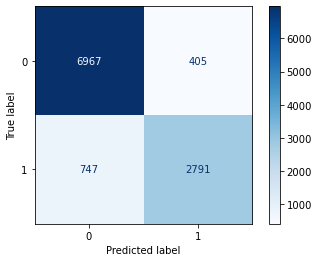

In [20]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

# make predictions on the test data
y_pred = TreeClassifier.predict(X_test)

# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# you can print the confusion matrix using
print(cm)

# alternatively, you can plot the confusion matrix using matplotlib
plot_confusion_matrix(TreeClassifier, X_test, y_test, cmap=plt.cm.Blues)

plt.show()

TODO grab the LUCAS images

In [27]:
pred_proba = TreeClassifier.predict_proba(X_test)

In [32]:
TreeClassifier.classes_

array([0, 1])

In [36]:
class_proba = []
for row in pred_proba:
    class_proba.append(max(row))

In [18]:
plt.hist(class_proba, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of pred_proba')
plt.show()

NameError: name 'class_proba' is not defined